In [ ]:
# import packages
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import scipy
import statistics
from scipy import interpolate
#from scipy.interpolate import UnivariateSpline

In [ ]:
def pointCurvature(a, b, c):
    """ Compute the three-point Menger Curvature using the shoelace formula to find triangle area. """
    area = 1/2 * np.abs((b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0]))
    denominator = np.linalg.norm(a - b) * np.linalg.norm(b - c) * np.linalg.norm(a - c)
    return 4 * area / denominator
    
def computeCurvature(curve, closed = False):
    """ Compute curvature of 2D curve (size 2 x n). """
    if (closed):
        curve = np.concatenate((np.reshape(curve[:, -1], (2, 1)), curve, np.reshape(curve[:, 0], (2, 1))), axis=1)
    curvature = np.zeros(curve.shape[1])
    for i in np.arange(1, curve.shape[1] - 1):
        curvature[i-1] = pointCurvature(curve[:, i-1], curve[:, i], curve[:, i+1])
    curvature[0] = curvature[1]
    curvature[-2] = curvature[-1]
    return curvature

def derivative(x, dt):
    xdot = np.zeros(x.shape)
    for i in np.arange(2, len(x)-2):
        xdot[i] = (x[i-2] - 8 * x[i-1] + 8 * x[i+1] - x[i+2])/(12 * dt)
    return xdot

def secondDerivative(x, dt):
    xdotdot = np.zeros(x.shape)
    for i in np.arange(2, len(x)-2):
        xdotdot[i] = (-x[i-2] + 16 * x[i-1] - 30 * x[i] + 16 * x[i+1] - x[i+2])/(12 * dt * dt)
    return xdotdot

def derivCurvature(curve, dt):
    return np.sqrt(np.gradient(np.gradient(curve[0], dt), dt)**2 + np.gradient(np.gradient(curve[1], dt), dt)**2)

# method for taking svg filename and reading/parsing/extracting curve
def processSVG(filename):
    file = open(filename, mode='r')
    data = file.readlines()
    file.close()
    all_points = re.search(r'points=\"(.*?)\"', data[0]).group(1)
    all_points = [float(x) for x in all_points.split()]
    curve = np.asarray([all_points[0::2], all_points[1::2]])
    return curve

# mean-subtract and divide by standard deviation
def normalizeCurve(curve):
    new_curve = np.zeros(curve.shape)
    new_curve[0,:] = (curve[0,:] - np.mean(curve[0,:]))/(np.max(curve[1,:]) - np.min(curve[1,:]))
    new_curve[1,:] = (curve[1,:] - np.mean(curve[1,:]))/(np.max(curve[1,:]) - np.min(curve[1,:]))
    return new_curve

# spline-interpolate given curve with n knot points
def interpCurve(curve, n):
    fit = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve, axis=1, k=4)
    new_curve = fit(np.linspace(0, curve.shape[1], n))
    return new_curve


# returns a spline fit to an input "curve", evaluated at "n" points with the given smoothing factor
def smoothCurve(curve, n, smoothing_factor):
    sx = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[0,:], k=4)
    sy = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[1,:], k=4)
    
    sx.set_smoothing_factor(smoothing_factor)
    sy.set_smoothing_factor(smoothing_factor)
    
    t = np.linspace(0, curve.shape[1], n)
    new_curve = np.zeros((2, n))
    new_curve[0,:] = sx(t)
    new_curve[1,:] = sy(t)
    return new_curve

# calculate smoother curve, calculate smooth curvature,
def smoothCurvature(curve, n, smoothing_factor):
    sx = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[0,:], k=4)
    sy = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curve[1,:], k=4)

    sx.set_smoothing_factor(smoothing_factor)
    sy.set_smoothing_factor(smoothing_factor)
    
    sxdot = sx.derivative()
    sydot = sy.derivative()
    
    sxdotdot = sxdot.derivative()
    sydotdot = sydot.derivative()

    sxdotdotdot = sxdotdot.derivative()
    sydotdotdot = sydotdot.derivative()
    
    t = np.linspace(0, curve.shape[1], n)
    new_curve = np.zeros((2, n))
    new_curve[0,:] = sx(t)
    new_curve[1,:] = sy(t)

    #calculate velocity
    velocity = sydot(t)/sxdot(t)

    #calculate acceleration
    acceleration = sydotdot(t)/sxdotdot(t)

    #calculate jerk
    jerk = sydotdotdot(t)/sxdotdotdot(t)
    
    # calculate curvature
    curvature = (sxdot(t) * sydotdot(t) - sydot(t) * sxdotdot(t))/(sxdot(t)**2 + sydot(t)**2)**(3/2)

    # spline fit to curvature
    try: 
        curv_spline = interpolate.UnivariateSpline(np.arange(curve.shape[1]), curvature)
    except: 
        print(len(np.arange(curve.shape[1])), len(curvature))
    curv_spline_eval = curv_spline(t)
    
    curv_dot_spline = curv_spline.derivative()
    curv_dot_eval = curv_dot_spline(t)
    
    # new_curve: interpolated/transformed curve, curv_spline_eval: curvature, curv_dot_eval: rate of change of curvature
    return new_curve, curvature, curv_dot_eval

#def smoothCurvatureAndCalculateDerivative(curvature, smoothing_factor):
#spline_fit = interpolate.UnivariateSpline(np.arange(len(curvature)), curvature)
#spline_fit.set_smoothing_factor(smoothing_factor)


# need to do:
# method to take in curve and return smoothed curvature and derivative of curvature
# method to take in curve and return two-point curvature-curvature correlation: int_0^t kappa(s) kappa(s+t) ds

In [ ]:
df = pd.read_csv('/work/ParkinsonHW/C_0003.txt', sep = ';', header = None)
df_static = df[df[6] == 0]
df_dynamic = df[df[6] == 1]
patientCurve_s = np.array([df_static[0], df_static[1]])
patientCurve_d = np.array([df_dynamic[0], df_dynamic[1]])
new_static = smoothCurvature(patientCurve_s, patientCurve_s.shape[1], 7500) # smoothing factor = m * v, where m = number of data points, v = variance of data (approximation)
new_dynamic = smoothCurvature(patientCurve_d, patientCurve_d.shape[1], 7500)

# interpolation error for last point: drop the last point when using the spline-fitted curve

Text(0.5, 1.0, 'Rate of Change of Interpolated Dynamic Curvature')

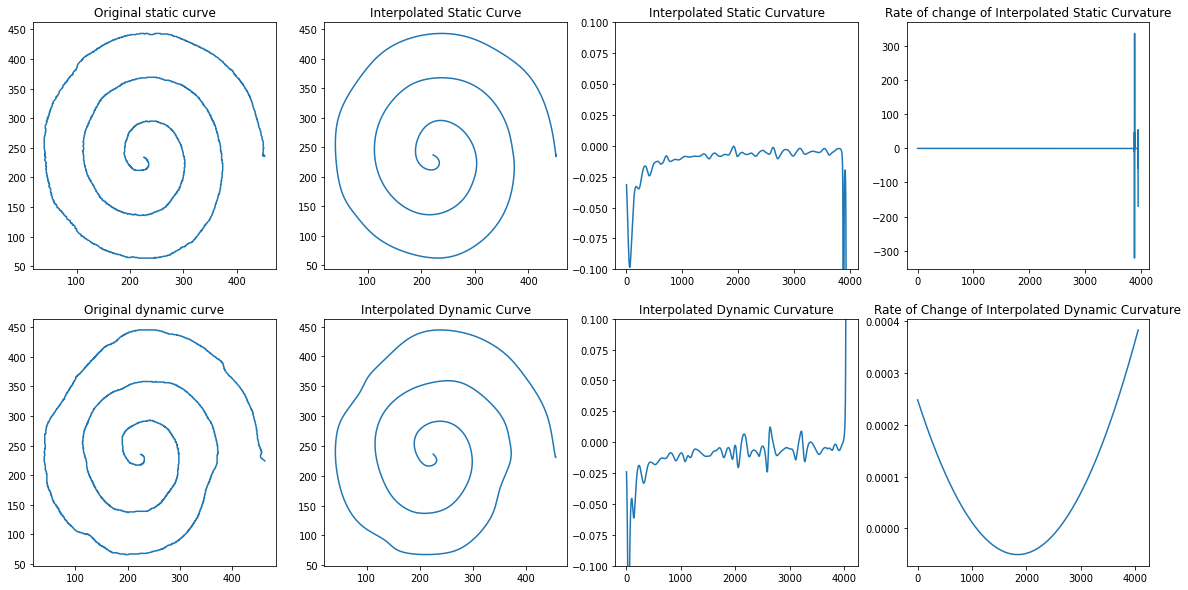

In [ ]:
# clockwise drawing of spiral - negative curvature; counterclockwise - positive curvature
# drawn from inner to outer here, so should be clockwise drawing, negative curvature
plt.figure(figsize = (20, 10))
plt.subplot(2, 4, 1)
plt.plot(df_static[0], df_static[1])
plt.title("Original static curve")
plt.subplot(2, 4, 2)
plt.plot(new_static[0][0], new_static[0][1])
plt.title("Interpolated Static Curve")
plt.subplot(2, 4, 3)
plt.ylim([-0.1, 0.1])
plt.plot(new_static[1])
plt.title("Interpolated Static Curvature")
plt.subplot(2, 4, 4)
plt.plot(new_static[2])
plt.title("Rate of change of Interpolated Static Curvature")

plt.subplot(2, 4, 5)
plt.plot(df_dynamic[0], df_dynamic[1])
plt.title("Original dynamic curve")
plt.subplot(2, 4, 6)
plt.plot(new_dynamic[0][0], new_dynamic[0][1])
plt.title("Interpolated Dynamic Curve")
plt.subplot(2, 4, 7)
plt.ylim([-0.1,0.1])
plt.plot(new_dynamic[1])
plt.title('Interpolated Dynamic Curvature')
plt.subplot(2, 4, 8)
plt.plot(new_dynamic[2])
plt.title("Rate of Change of Interpolated Dynamic Curvature")

In [ ]:
df_p = pd.read_csv('/work/ParkinsonHW/P_09100001.txt', sep = ';', header = None)
df_static_p = df_p[df_p[6] == 0]
df_dynamic_p = df_p[df_p[6] == 1]
patientCurve_sp = np.array([df_static_p[0], df_static_p[1]])
patientCurve_dp = np.array([df_dynamic_p[0], df_dynamic_p[1]])
new_staticp = smoothCurvature(patientCurve_sp, patientCurve_sp.shape[1], 5000)
new_dynamicp = smoothCurvature(patientCurve_dp, patientCurve_dp.shape[1], 5000)

Text(0.5, 1.0, 'Rate of Change of Interpolated Dynamic Curvature')

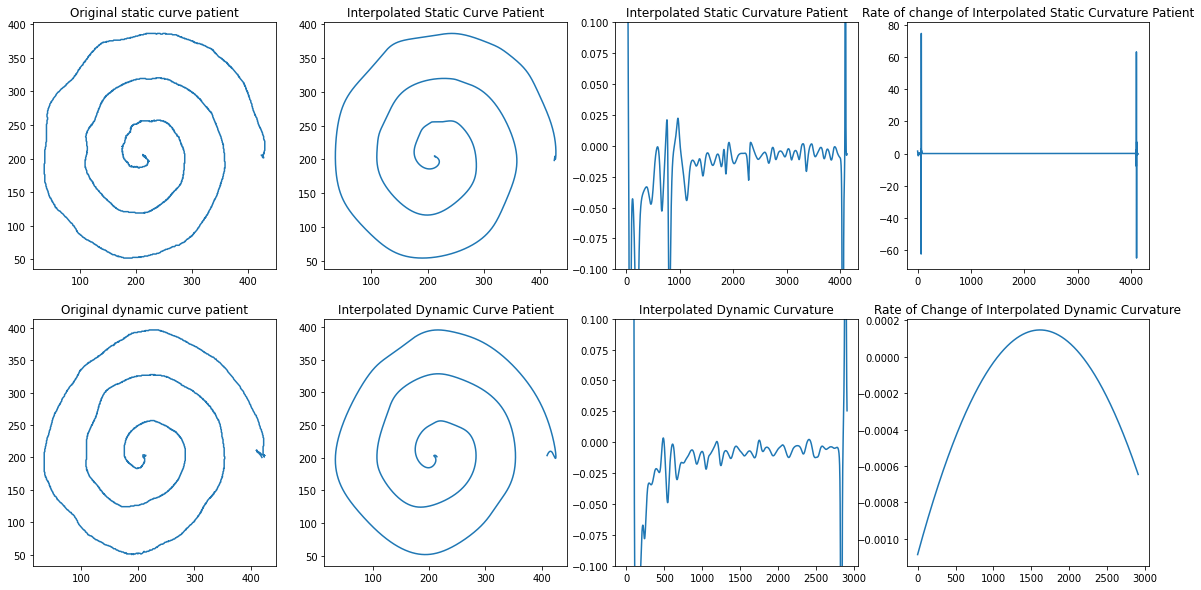

In [ ]:
plt.figure(figsize = (20, 10))
plt.subplot(2, 4, 1)
plt.plot(df_static_p[0], df_static_p[1])
plt.title("Original static curve patient")
plt.subplot(2, 4, 2)
plt.plot(new_staticp[0][0], new_staticp[0][1])
plt.title("Interpolated Static Curve Patient")
plt.subplot(2, 4, 3)
plt.ylim([-0.1, 0.1])
plt.plot(new_staticp[1])
plt.title("Interpolated Static Curvature Patient")
plt.subplot(2, 4, 4)
plt.plot(new_staticp[2])
plt.title("Rate of change of Interpolated Static Curvature Patient")

plt.subplot(2, 4, 5)
plt.plot(df_dynamic_p[0], df_dynamic_p[1])
plt.title("Original dynamic curve patient")
plt.subplot(2, 4, 6)
plt.plot(new_dynamicp[0][0], new_dynamicp[0][1])
plt.title("Interpolated Dynamic Curve Patient")
plt.subplot(2, 4, 7)
plt.ylim([-0.1,0.1])
plt.plot(new_dynamicp[1])
plt.title('Interpolated Dynamic Curvature')
plt.subplot(2, 4, 8)
plt.plot(new_dynamicp[2])
plt.title("Rate of Change of Interpolated Dynamic Curvature")